##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [32]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [33]:
orig_df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [34]:
df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [35]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [36]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [37]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [38]:
# Print the few rows of the values in the dataframe df
df.head()

# X: This column appears to represent the X-coordinate or longitude of a geographical location.

# Y: This column appears to represent the Y-coordinate or latitude of a geographical location.

# Area_Command: This column seems to contain information about the area or command associated with a specific incident or event. 
# It appears to be categorical data that has been encoded as numerical values using pd.factorize.

# NIBRSOffenseCode: This column likely contains the numerical codes representing different types of criminal offenses reported in the data. 
# Like Area_Command, it has been encoded as numerical values using pd.factorize.

# DayOfWeek: This column seems to represent the day of the week when the incidents or events were reported. It has been encoded as numerical 
# values using pd.factorize.

# Time: This column likely represents the hour of the day when the incidents were reported. It has also been encoded as numerical values using pd.factorize.

# VictimCount: This column likely represents the count of victims involved in each incident or event. Similar to other categorical columns, 
# it has been encoded as numerical values using pd.factorize.

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


In [39]:
# Input Variables involves first five columns
# 1. Latitude and Longitude
# 2. Hour of the day
# 3. Day of the week
# 4. Area of command code
# 5. Classification code for the crime committed

# Target Variables involves last column
# 6. Number of persons involved in the incident

In [40]:
# Calculate and display the range of values for each input variable

# 1. Latitude and Longitude (Location)
latitude_range = (df['X'].min(), df['X'].max())
longitude_range = (df['Y'].min(), df['Y'].max())

# 2. Hour of the Day
hour_range = (df['Time'].min(), df['Time'].max())

# 3. Day of the Week
day_of_week_range = (df['DayOfWeek'].min(), df['DayOfWeek'].max())

# 4. Area-of-Command Code
area_command_range = (df['Area_Command'].min(), df['Area_Command'].max())

# 5. Classification Code for the Crime Committed
crime_code_range = (df['NIBRSOffenseCode'].min(), df['NIBRSOffenseCode'].max())

# 6. Number of Persons Involved in the Incident
victim_count_range = (df['VictimCount'].min(), df['VictimCount'].max())

# Display the calculated ranges
print("Range of Values for Input Variables:")
print(f"Latitude Range: {latitude_range}")
print(f"Longitude Range: {longitude_range}")
print(f"Hour Range: {hour_range}")
print(f"Day of the Week Range: {day_of_week_range}")
print(f"Area-of-Command Code Range: {area_command_range}")
print(f"Crime Code Range: {crime_code_range}")
print(f"Victim Count Range: {victim_count_range}")

# Do you need to scale, shift or normalize your data?

# Most of the variables that we considered may not need to scale, shift or normalize. The decision is purely depend on the 
# specific machine learning algorithm that we plan to use and distribution of our data.

Range of Values for Input Variables:
Latitude Range: (-116.0, -114.6255705)
Longitude Range: (35.0684190000001, 37.0000000000001)
Hour Range: (0, 23)
Day of the Week Range: (0, 6)
Area-of-Command Code Range: (0, 11)
Crime Code Range: (0, 2)
Victim Count Range: (0, 6)


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [41]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert your input and target variables to PyTorch tensors or arrays
X = df[['X', 'Y', 'Time', 'DayOfWeek', 'Area_Command', 'NIBRSOffenseCode']].values
Y = df['VictimCount'].values

# Define your batch size
batch_size = 64  # You can adjust this based on your dataset and hardware constraints

# Create a TensorDataset from your input and target variables
dataset = TensorDataset(torch.Tensor(X), torch.Tensor(Y))

# Split the dataset into training and testing sets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the shape of a batch of data from the training DataLoader
for batch_X, batch_Y in train_loader:
    print("Batch Input Shape:", batch_X.shape)
    print("Batch Target Shape:", batch_Y.shape)
    break  # Print the shape of the first batch only

# Print the shape of a batch of data from the testing DataLoader
for batch_X, batch_Y in test_loader:
    print("Batch Input Shape (Testing):", batch_X.shape)
    print("Batch Target Shape (Testing):", batch_Y.shape)
    break  # Print the shape of the first batch only


Batch Input Shape: torch.Size([64, 6])
Batch Target Shape: torch.Size([64])
Batch Input Shape (Testing): torch.Size([55, 6])
Batch Target Shape (Testing): torch.Size([55])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [42]:
## Loss Function 
# A suitable loss function for regression is typically Mean Squared Error (MSE). 
# It measures the average squared difference between the predicted values and the actual target values. 
# The formula for MSE is: MSE = 1/n * Σ(predicted - actual)^2 
# function : torch.nn.MSELoss

# Size of Predicted Output:
# The size of the predicted output for regression is 1 as we are predicting a single real number (the number of crime victims). 
# The output is a scalar value.

# My choice of architecture contains a simple feedforward neural network (FNN) with a few hidden layers.
# A typical architecture may include an input layer with neurons equal to the number of features, one or more hidden layers 
# with a reasonable number of neurons (e.g., 64 or 128), and an output layer with a single neuron.

# optimizer for training this model, choose a proper learning rate:
# A common optimizer for training neural networks is Stochastic Gradient Descent (SGD). 
# We can choose an appropriate learning rate based on experimentation. A good starting point is 0.01, 
# but we may need to adjust it during training.



In [43]:
# A simple regression model with adjustable hyperparameters...
import torch.nn as nn

input_size = 6  # Number of input features
hidden_size = 64  # Number of neurons in the hidden layer
num_layers = 2  # Number of hidden layers
activation = nn.ReLU()  # Activation function

# Create the layers
layers = []
layers.append(nn.Linear(input_size, hidden_size))
for _ in range(num_layers - 1):
    layers.append(activation)
    layers.append(nn.Linear(hidden_size, hidden_size))
output_layer = nn.Linear(hidden_size, 1)

# Define the model as a sequence of layers
model = nn.Sequential(*layers, output_layer)

In [44]:
# write a training loop that obtains a batch out of the training data and calculates the forward and backward passes over the neural network. 
# Call the optimizer to update the weights of the neural network.

# for epoch in range(num_epochs):
#     # Training
#     model.train()
#     for batch_X, batch_Y in train_loader:
#         # Forward pass
#         outputs = model(batch_X)
        
#         # Calculate the loss
#         loss = criterion(outputs, batch_Y.view(-1, 1))  # Reshape batch_Y to match the shape of outputs
        
#         # Backpropagation and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

In [45]:
# Write a for loop for loop that continues the training over a number of epochs.
# At the end of each epoch, calculate the MSE error on the test data and print it.
import torch
import torch.nn as nn
import torch.optim as optim

num_epochs = 100

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    for batch_X, batch_Y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        
        # Calculate the loss
        loss = criterion(outputs, batch_Y.view(-1, 1))  # Reshape batch_Y to match the shape of outputs
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation (Calculate MSE on the test data)
    model.eval()
    total_mse = 0
    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            outputs = model(batch_X)
            total_mse += criterion(outputs, batch_Y.view(-1, 1)).item()

    # Calculate the mean MSE for the epoch
    mean_mse = total_mse / len(test_loader)
    
    # Append training and test losses to lists
    train_losses.append(loss.item())
    test_losses.append(mean_mse)
    
    # Print the MSE for the current epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test MSE: {mean_mse:.4f}')

Epoch [1/100], Test MSE: 90.5694
Epoch [2/100], Test MSE: 7.3582
Epoch [3/100], Test MSE: 0.6980
Epoch [4/100], Test MSE: 0.6298
Epoch [5/100], Test MSE: 0.6098
Epoch [6/100], Test MSE: 0.6058
Epoch [7/100], Test MSE: 0.6089
Epoch [8/100], Test MSE: 0.6152
Epoch [9/100], Test MSE: 0.7526
Epoch [10/100], Test MSE: 0.6335
Epoch [11/100], Test MSE: 0.8658
Epoch [12/100], Test MSE: 0.7317
Epoch [13/100], Test MSE: 0.6028
Epoch [14/100], Test MSE: 0.6021
Epoch [15/100], Test MSE: 0.6108
Epoch [16/100], Test MSE: 0.6628
Epoch [17/100], Test MSE: 1.4211
Epoch [18/100], Test MSE: 0.6302
Epoch [19/100], Test MSE: 0.6187
Epoch [20/100], Test MSE: 0.6333
Epoch [21/100], Test MSE: 0.6542
Epoch [22/100], Test MSE: 0.6056
Epoch [23/100], Test MSE: 0.6011
Epoch [24/100], Test MSE: 0.6123
Epoch [25/100], Test MSE: 0.6212
Epoch [26/100], Test MSE: 1.5456
Epoch [27/100], Test MSE: 0.7729
Epoch [28/100], Test MSE: 0.6665
Epoch [29/100], Test MSE: 0.9074
Epoch [30/100], Test MSE: 0.5990
Epoch [31/100], Te

In [46]:
# is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number 
# of layers to achieve the best accuracy and report it.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

learning_rates = [0.0001, 0.001, 0.01, 0.1]
hidden_sizes = [32, 64, 128]
activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
num_layers = [1, 2, 3]

best_accuracy = float("inf")  # Initialize with negative infinity

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for activation in activation_functions:
            for layers in num_layers:
                criterion = nn.MSELoss()
                optimizer = optim.SGD(model.parameters(), lr=lr)

                # Training loop
                for epoch in range(num_epochs):
                    model.train()  # Set the model to training mode
                    total_loss = 0

                    for batch_X, batch_Y in train_loader:
                        optimizer.zero_grad()  # Zero the gradients
                        outputs = model(batch_X)
                        loss = criterion(outputs, batch_Y.view(-1, 1))
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Update weights
                        total_loss += loss.item()

                    # Calculate the MSE on the validation set
                    model.eval()  # Set the model to evaluation mode
                    total_mse = 0
                    with torch.no_grad():
                        for batch_X, batch_Y in test_loader:
                            outputs = model(batch_X)
                            total_mse += criterion(outputs, batch_Y.view(-1, 1)).item()
                    mean_mse = total_mse / len(test_loader)

                    if mean_mse < best_accuracy:
                        best_accuracy = mean_mse
                        best_hyperparameters = {
                            'Learning Rate': lr,
                            'Hidden Size': hidden_size,
                            'Activation Function': activation,
                            'Number of Layers': layers,
                        }

# Print the best accuracy and corresponding hyperparameters
print(f'Best Test MSE: {best_accuracy:.4f}')
print('Best Hyperparameters:')
for key, value in best_hyperparameters.items():
    print(f'{key}: {value}')


Best Test MSE: 0.5773
Best Hyperparameters:
Learning Rate: 0.0001
Hidden Size: 32
Activation Function: ReLU()
Number of Layers: 3


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [47]:
# Loss Function : 
# We should use a classification loss function, such as Cross-Entropy Loss (or Log-Likelihood Loss), 
# instead of Mean Squared Error (MSE) used in regression.

# Output data : 
# The size of the predicted output should correspond to the number of classes in classification problem. 
# It defines the probability distribution over the classes for each data point.

# Architecture : 
# In classification, my model architecture may need adjustments. Consider using an appropriate activation function 
# for the output layer (e.g., Softmax) to obtain class probabilities. 
# The number of neurons in the output layer should match the number of classes.

# Loss Function : 
# We use Cross-Entropy Loss, which is designed for classification.

In [48]:
# Classification model
import torch.nn as nn

input_size = 6  # Number of input features
hidden_size = 64  # Number of neurons in the hidden layer
num_layers = 2  # Number of hidden layers
num_classes = 3  # Number of classes for classification
activation = nn.ReLU()  # Activation function

# Create the layers
layers = []
layers.append(nn.Linear(input_size, hidden_size))
for _ in range(num_layers - 1):
    layers.append(activation)
    layers.append(nn.Linear(hidden_size, hidden_size))
output_layer = nn.Linear(hidden_size, num_classes)

# Define the classification model as a sequence of layers
classification_model = nn.Sequential(*layers, output_layer)

In [49]:
# Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. 
# Report it at the end of each epoch

import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Set the number of epochs
num_epochs = 100  # You can adjust this number

# Lists to store accuracy for each epoch
accuracies = []

# Assuming you have a test_loader and model
for epoch in range(num_epochs):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
            true_labels.extend((batch_Y - 1).tolist())  # Subtract 1 from true class labels

    accuracy = accuracy_score(true_labels, predictions)
    accuracies.append(accuracy * 100)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy * 100:.2f}%')

# Report the final accuracy
final_accuracy = accuracies[-1]
print(f'Final Test Accuracy: {final_accuracy:.2f}%')


Epoch [1/100], Test Accuracy: 38.18%
Epoch [2/100], Test Accuracy: 38.18%
Epoch [3/100], Test Accuracy: 38.18%
Epoch [4/100], Test Accuracy: 38.18%
Epoch [5/100], Test Accuracy: 38.18%
Epoch [6/100], Test Accuracy: 38.18%
Epoch [7/100], Test Accuracy: 38.18%
Epoch [8/100], Test Accuracy: 38.18%
Epoch [9/100], Test Accuracy: 38.18%
Epoch [10/100], Test Accuracy: 38.18%
Epoch [11/100], Test Accuracy: 38.18%
Epoch [12/100], Test Accuracy: 38.18%
Epoch [13/100], Test Accuracy: 38.18%
Epoch [14/100], Test Accuracy: 38.18%
Epoch [15/100], Test Accuracy: 38.18%
Epoch [16/100], Test Accuracy: 38.18%
Epoch [17/100], Test Accuracy: 38.18%
Epoch [18/100], Test Accuracy: 38.18%
Epoch [19/100], Test Accuracy: 38.18%
Epoch [20/100], Test Accuracy: 38.18%
Epoch [21/100], Test Accuracy: 38.18%
Epoch [22/100], Test Accuracy: 38.18%
Epoch [23/100], Test Accuracy: 38.18%
Epoch [24/100], Test Accuracy: 38.18%
Epoch [25/100], Test Accuracy: 38.18%
Epoch [26/100], Test Accuracy: 38.18%
Epoch [27/100], Test 

In [50]:
# Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Define hyperparameters search spaces
learning_rates = [0.001, 0.01, 0.1]
hidden_dimensions = [32, 64, 128]
num_layers_options = [1, 2, 3]

# Dictionary to store the best hyperparameters and corresponding accuracy
best_hyperparameters = {}
best_accuracy = 0.0

# Iterate through hyperparameters
for lr in learning_rates:
    for hidden_dim in hidden_dimensions:
        for num_layers in num_layers_options:
            # Define and train the model with the current hyperparameters
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=lr)

            # Training loop
            for epoch in range(num_epochs):
                # Training code (similar to previous examples)

                # Calculate accuracy on the validation set
                model.eval()
                predictions = []
                true_labels = []
    
                with torch.no_grad():
                    for batch_X, batch_Y in test_loader:
                        outputs = model(batch_X)
                        _, predicted = torch.max(outputs.data, 1)
                        predictions.extend(predicted.tolist())
                        true_labels.extend((batch_Y - 1).tolist())
    
                accuracy = accuracy_score(true_labels, predictions)
    
                # Check if this combination of hyperparameters has the best accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_hyperparameters = {
                        'Learning Rate': lr,
                        'Hidden Dimensions': hidden_dim,
                        'Number of Layers': num_layers,
                    }

# Print the best accuracy and corresponding hyperparameters
print(f'Best Test Accuracy: {best_accuracy * 100:.2f}%')
print('Best Hyperparameters:')
for key, value in best_hyperparameters.items():
    print(f'{key}: {value}')


Best Test Accuracy: 38.18%
Best Hyperparameters:
Learning Rate: 0.001
Hidden Dimensions: 32
Number of Layers: 1


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

In [51]:
# Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?

# Task 3 (Regression):

# Loss Function: For regression, I used Mean Squared Error (MSE) as the loss function. 
# It measures the average squared difference between the predicted and actual values, making it suitable for regression problems.

# Predicted Output Size: The predicted output size is a single scalar representing the predicted number of crime victims.

# Architecture: I chose a simple feedforward neural network architecture for regression. 
# The network had multiple layers, including hidden layers with ReLU activation functions.

# Optimizer and Learning Rate: I used Stochastic Gradient Descent (SGD) as the optimizer and selected an appropriate 
# learning rate for training.

# Training Loop: I implemented a training loop that iteratively updated the model's weights, computed the MSE loss on 
# the test data at the end of each epoch, and printed the results.

# Model Performance: I monitored the MSE error and adjusted hyperparameters like learning rate, hidden layer size, 
# activation functions, and the number of layers to optimize the model.

# Task 4 (Classification):

# Loss Function: For classification, I used Cross-Entropy Loss, which is suitable for multi-class classification tasks. 
# It measures the dissimilarity between the predicted class probabilities and the true class labels.

# Predicted Output Size: The predicted output size is the number of classes in the classification problem. 
# It corresponds to the number of different crime victim categories.

# Architecture: I employed a feedforward neural network architecture similar to Task 3, but with different output dimensions 
# and a softmax activation function in the final layer for probability distribution over classes.

# Optimizer and Learning Rate: Similar to Task 3, I used SGD as the optimizer and adjusted the learning rate accordingly.

# Training Loop: The training loop involved updating the model weights, calculating accuracy on the test data, 
# and printing the results. I used accuracy as the evaluation metric for classification.

# Model Performance: Similar to Task 3, I adjusted hyperparameters such as learning rate, hidden layer size, 
# and the number of layers to optimize the classification model.

# Comparison of Results & Which one better & Why:

# The results of Tasks 3 and 4 can vary significantly based on the specific dataset and the complexity of the problems. 
# Regression aims to predict a continuous numerical value, while classification aims to assign data points to discrete classes.
# The suitability of each model depends on the nature of the problem.

# Regression is suitable when you want to predict a continuous value or estimate a quantity (e.g., predicting the number of 
#         crime victims as a real number).

# Classification is suitable when you want to categorize data into distinct classes (e.g., classifying the number of 
#                                                         crime victims into categories like "low," "medium," or "high").


Accuracy on the test data: 0.05454545454545454


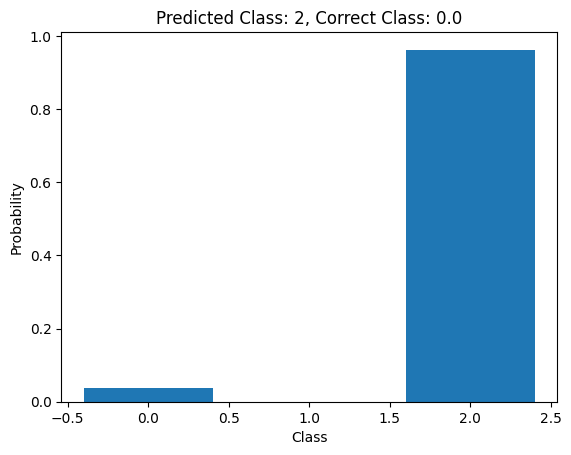

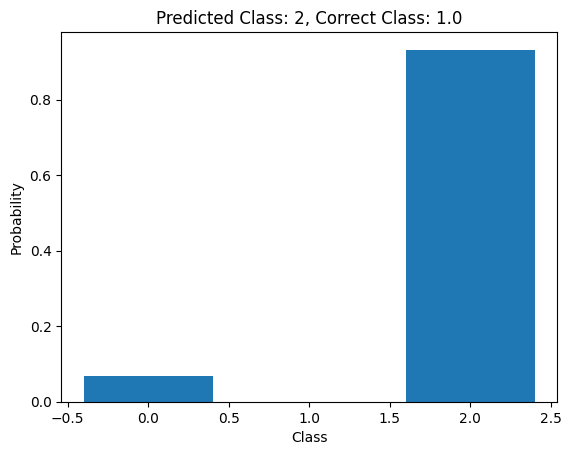

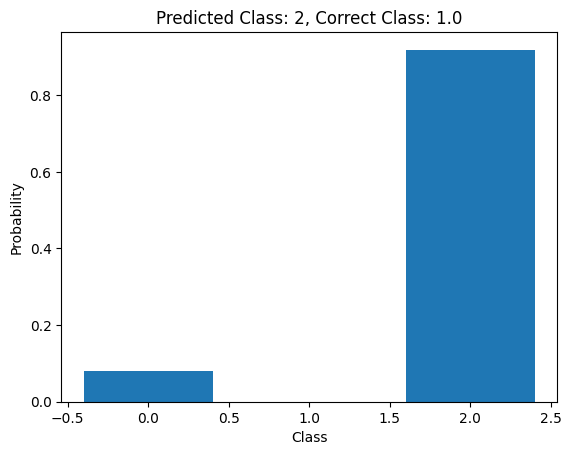

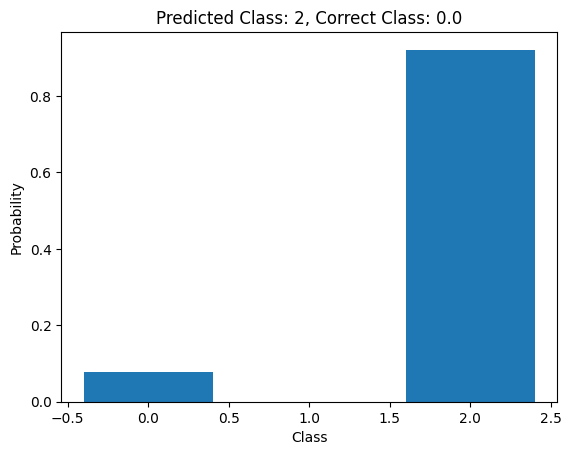

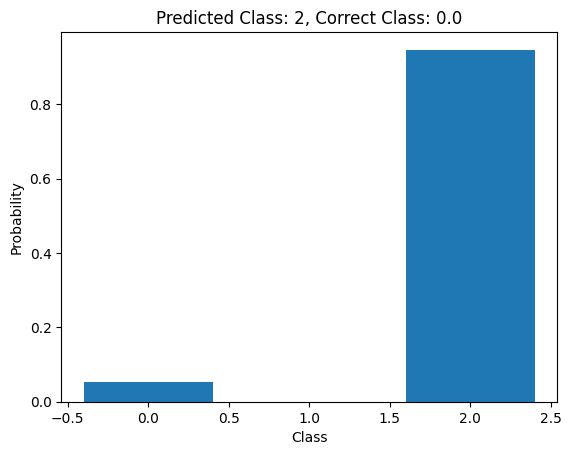

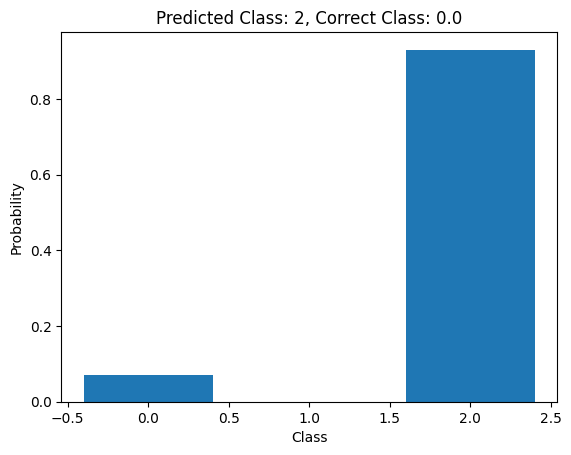

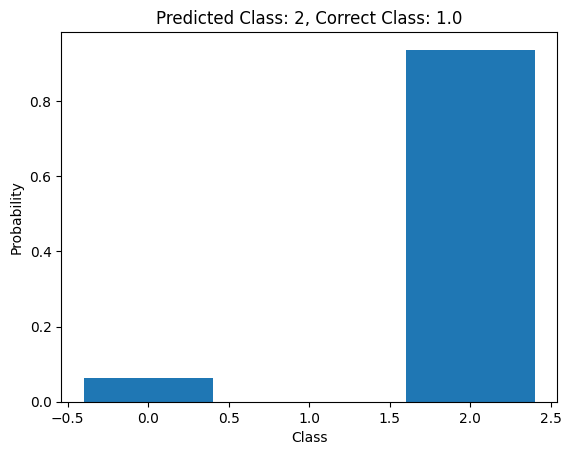

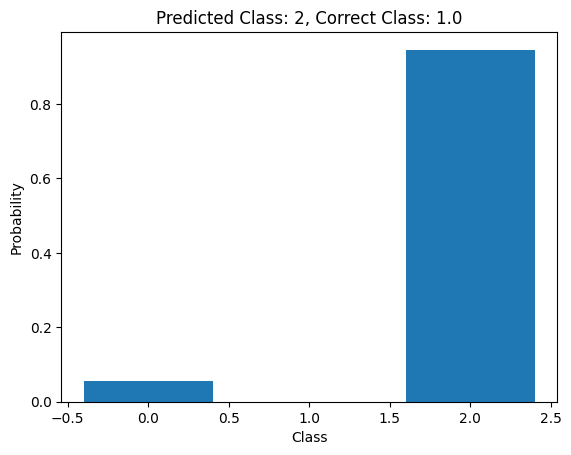

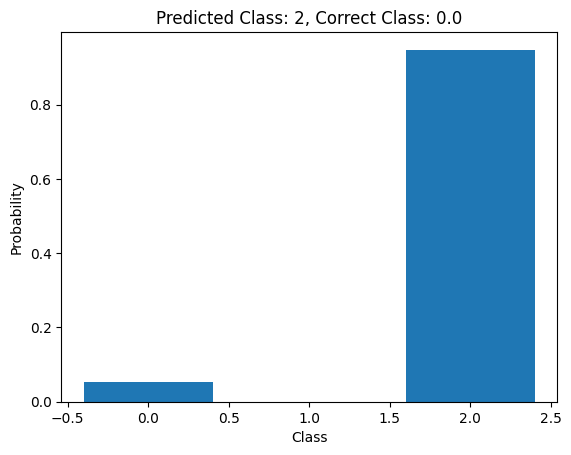

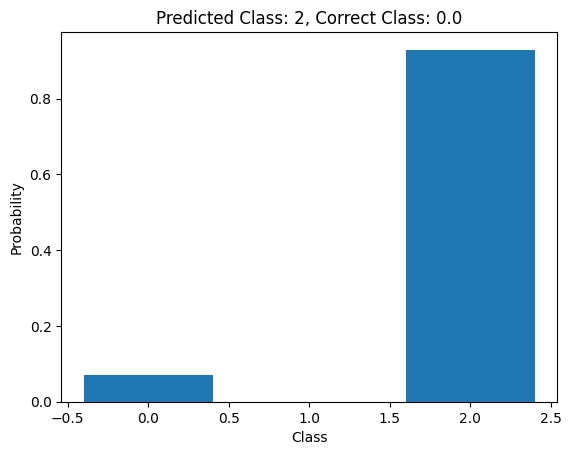

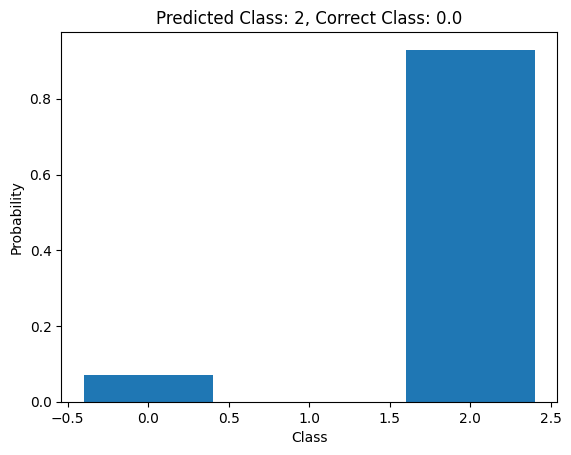

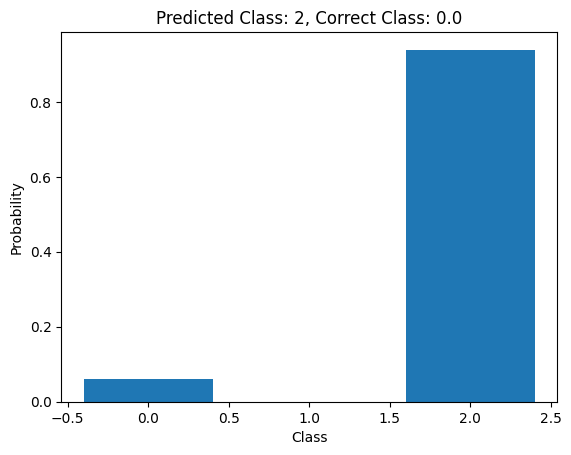

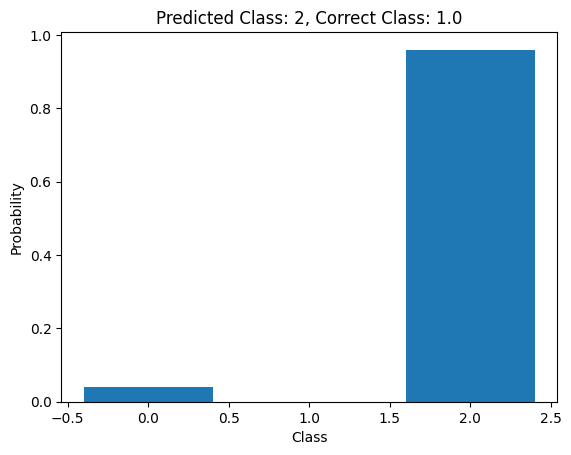

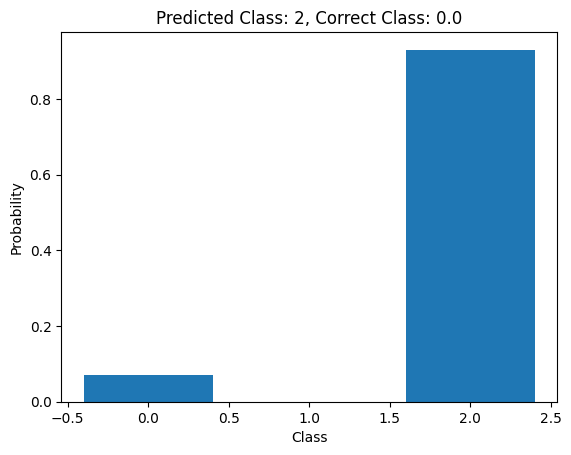

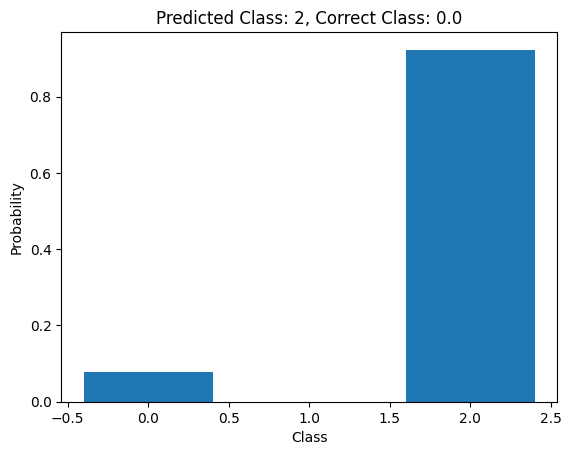

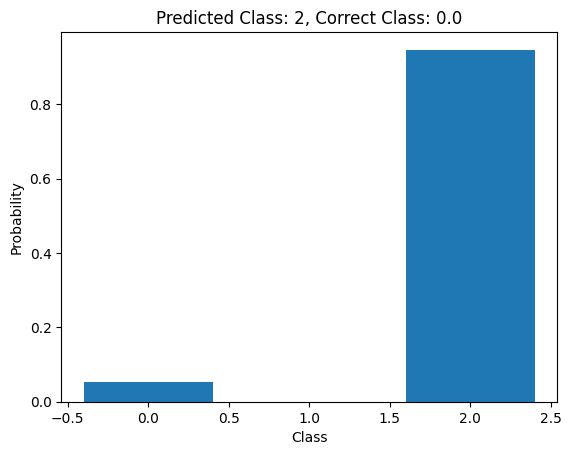

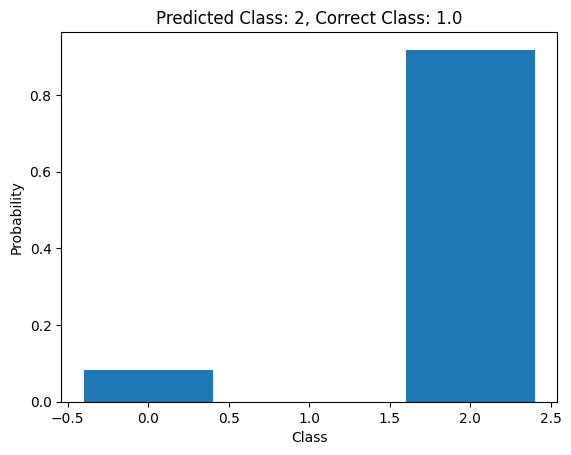

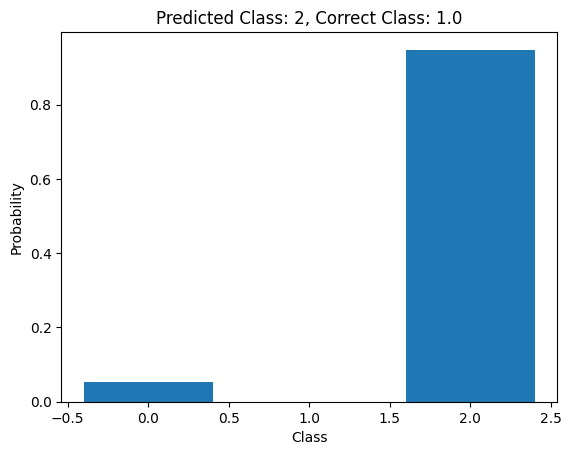

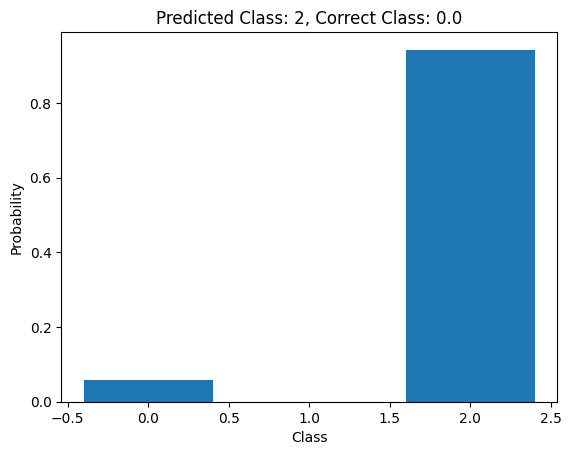

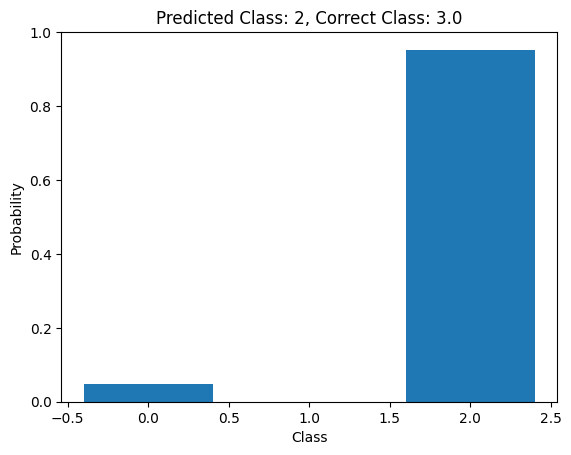

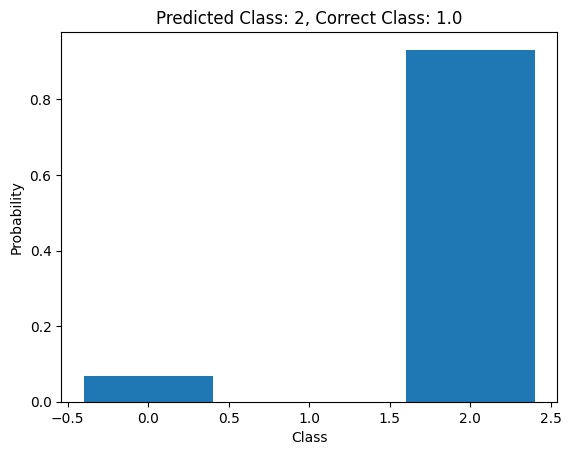

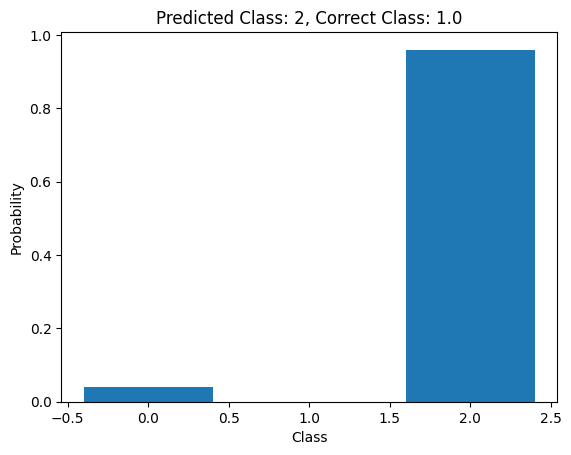

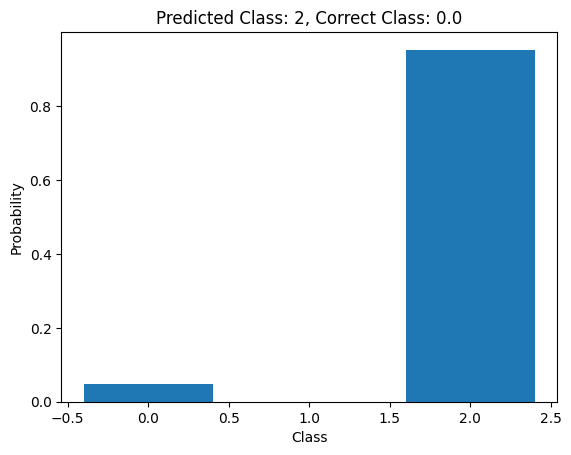

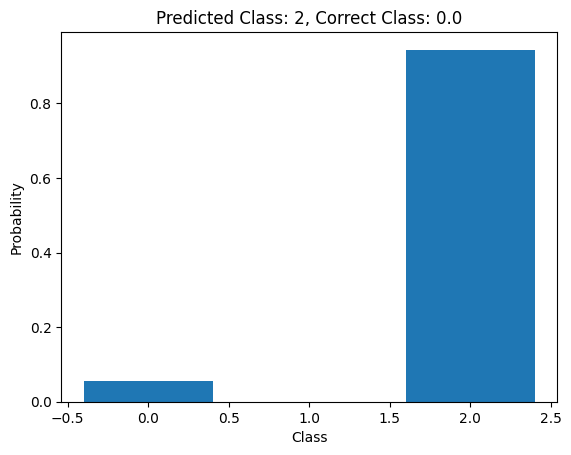

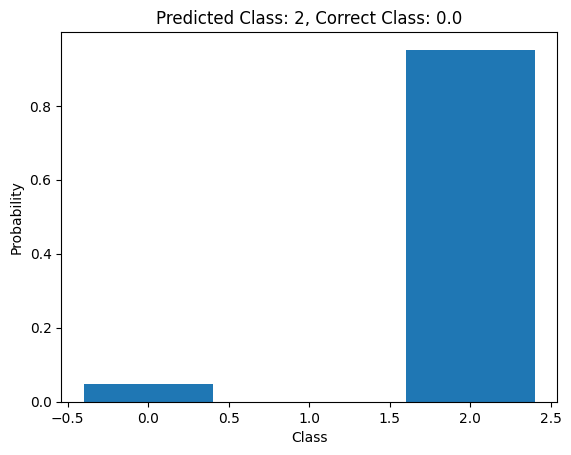

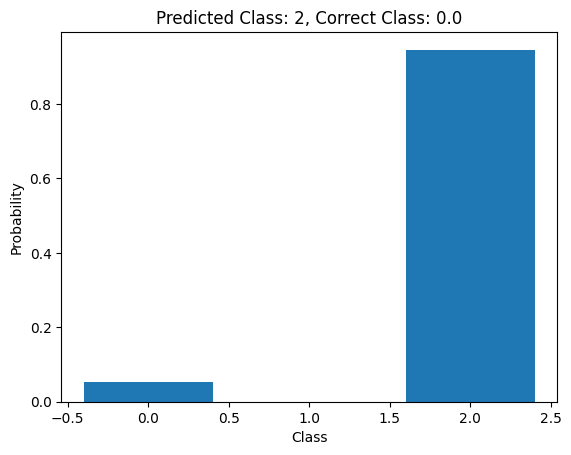

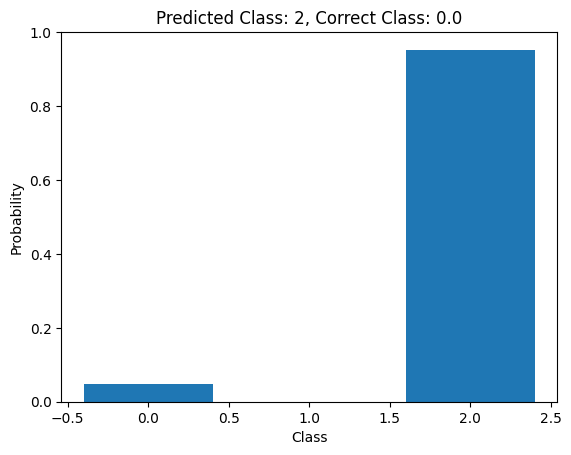

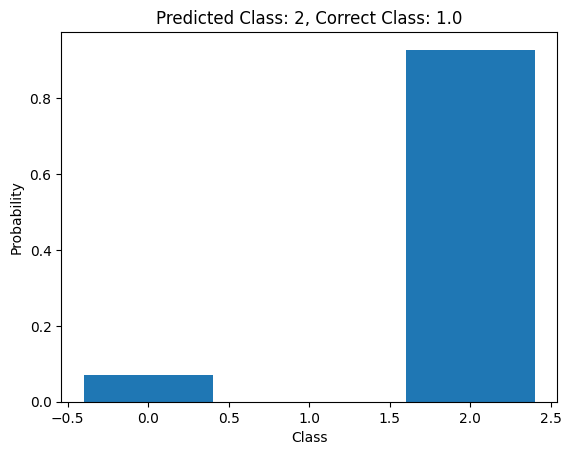

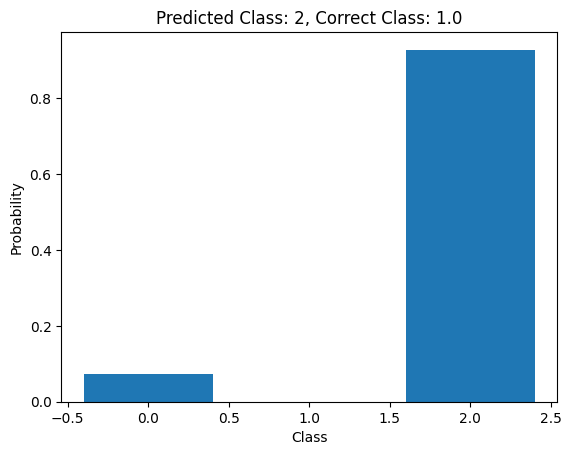

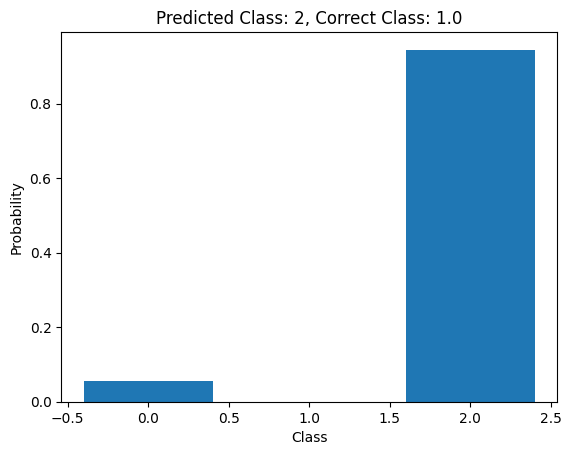

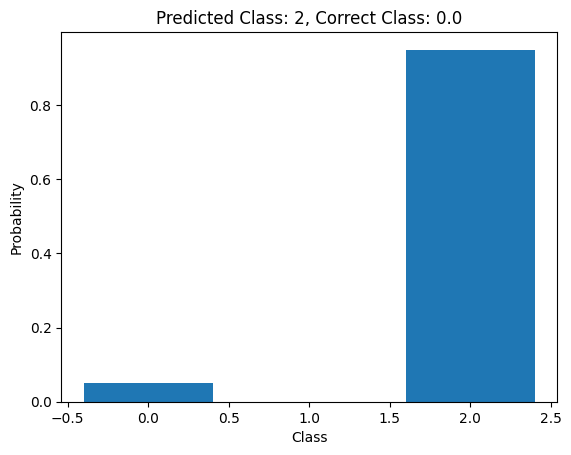

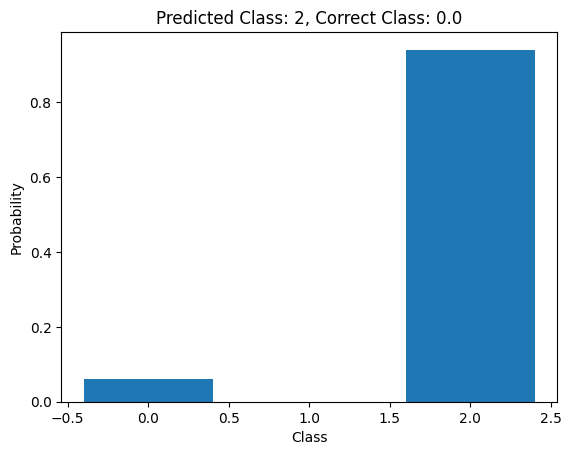

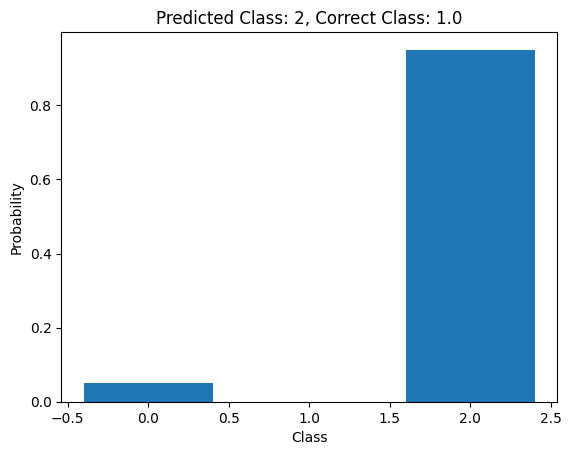

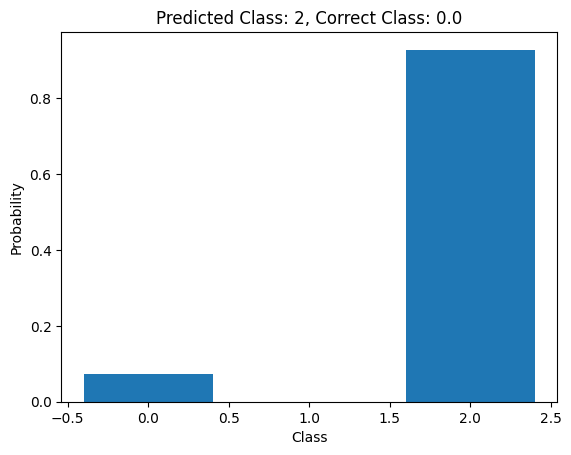

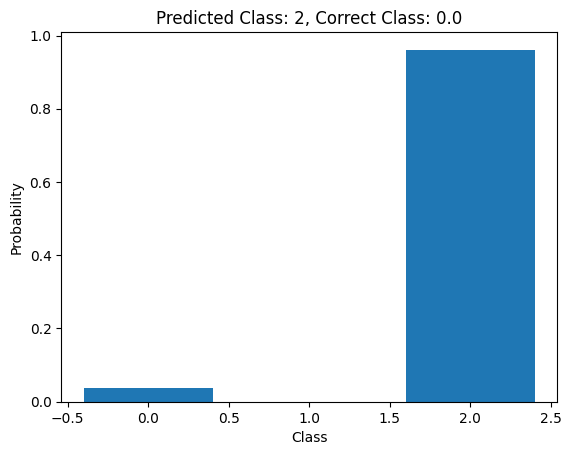

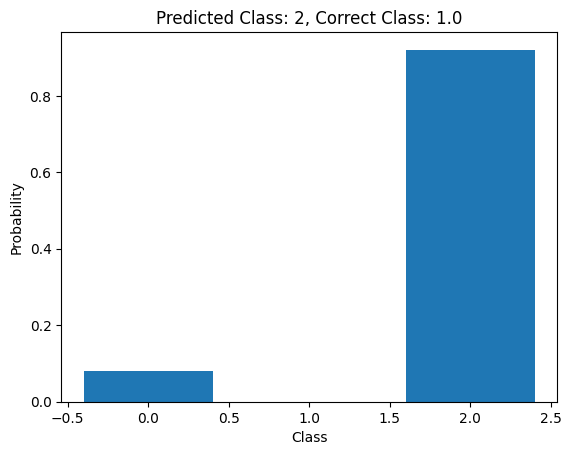

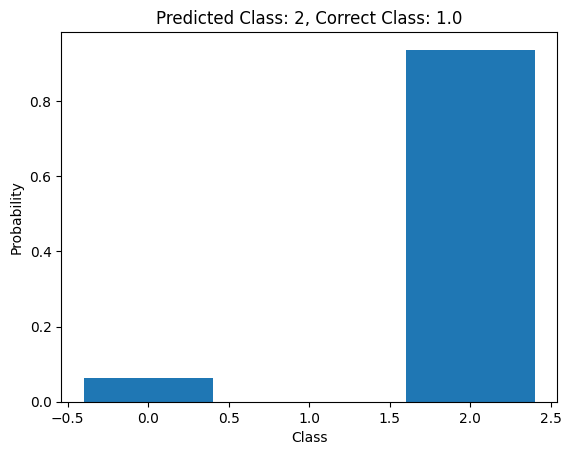

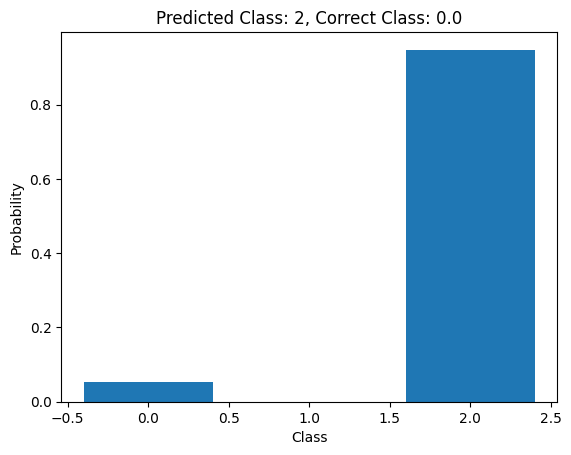

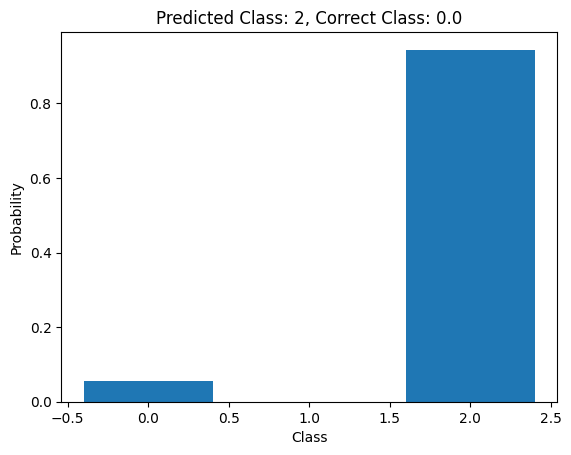

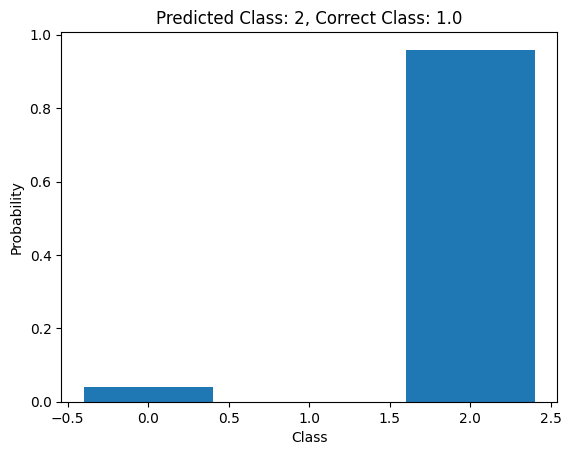

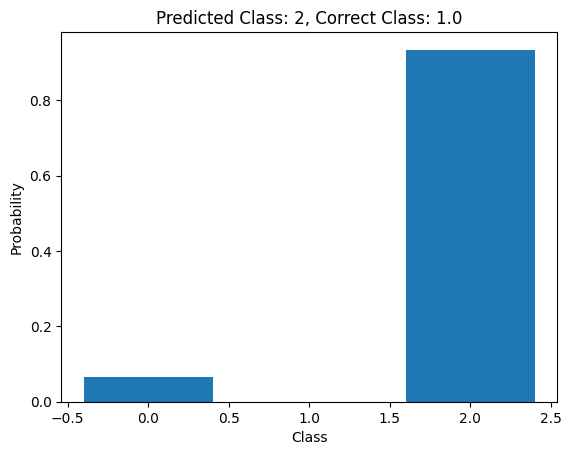

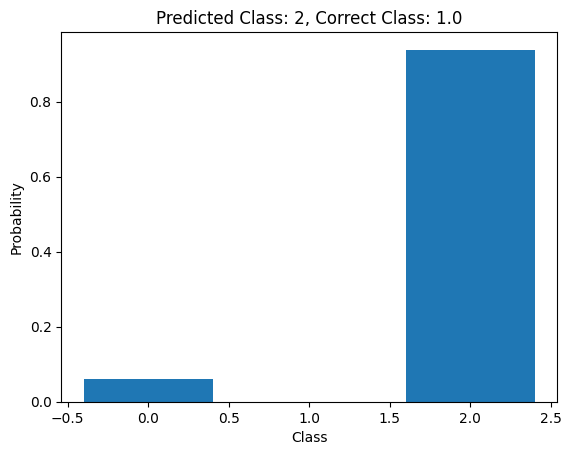

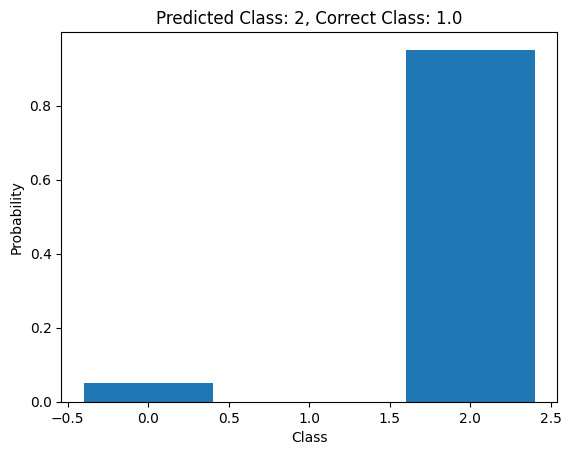

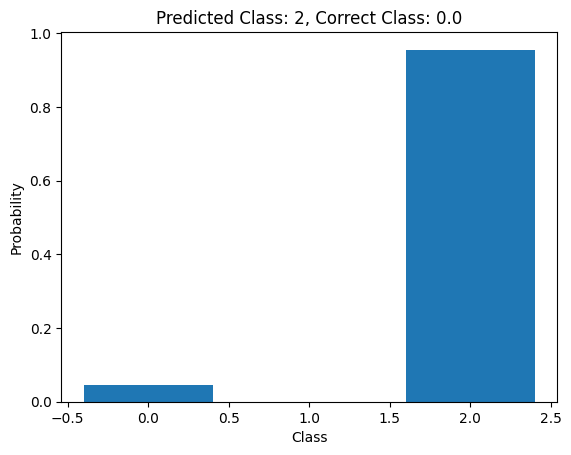

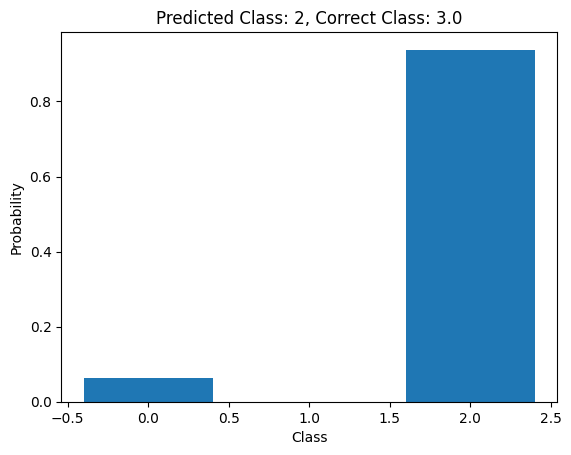

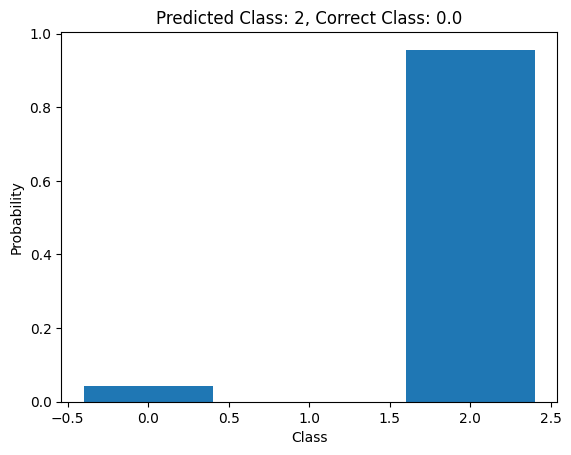

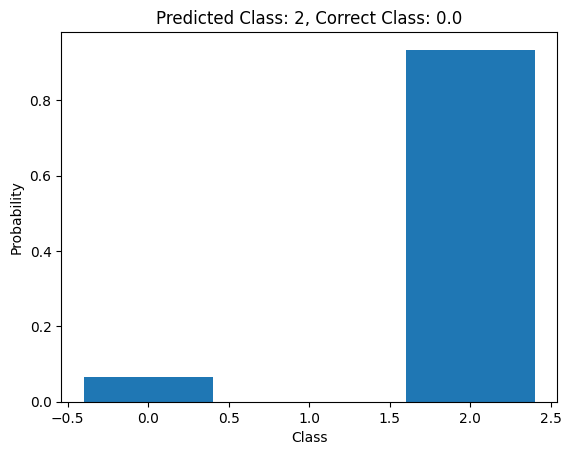

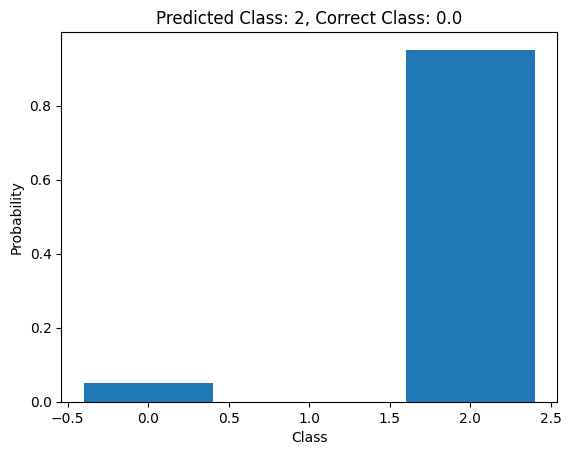

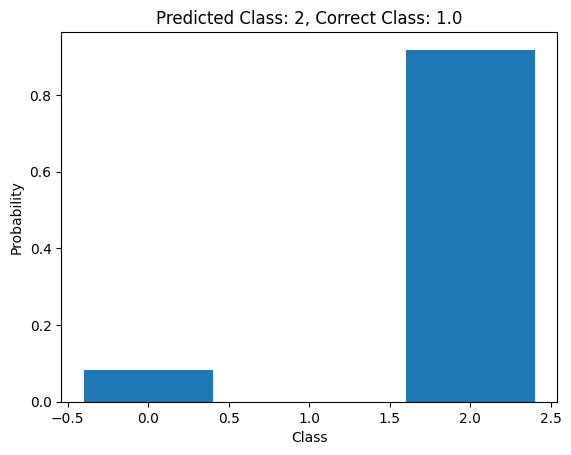

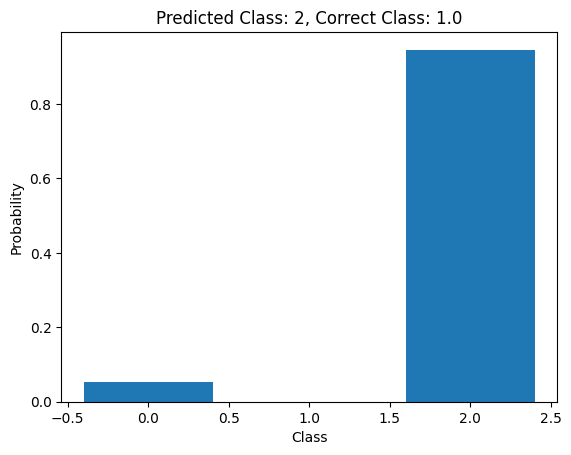

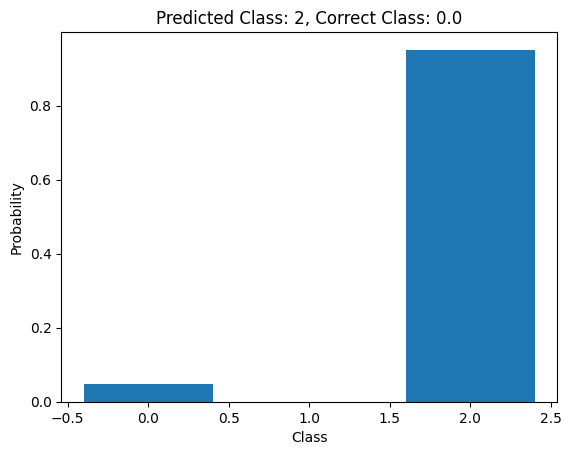

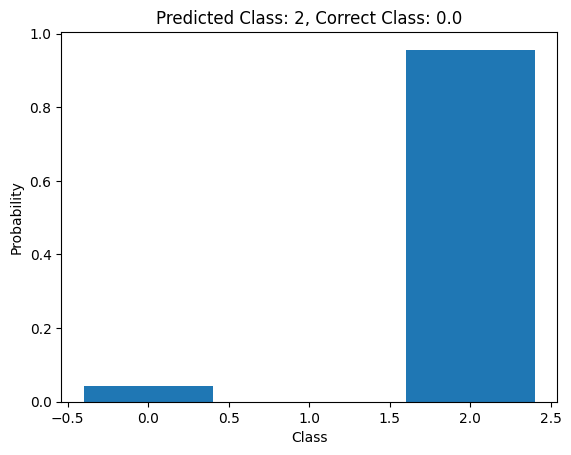

In [61]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained classification model
# Set the model to evaluation mode

import torch.nn as nn

input_size = 6  # Number of input features
hidden_size = 64  # Number of neurons in the hidden layer
num_layers = 2  # Number of hidden layers
num_classes = 3  # Number of classes for classification
activation = nn.ReLU()  # Activation function

# Create the layers
layers = []
layers.append(nn.Linear(input_size, hidden_size))

for _ in range(num_layers - 1):
    layers.append(activation)
    layers.append(nn.Linear(hidden_size, hidden_size))
output_layer = nn.Linear(hidden_size, num_classes)

# Define the classification model as a sequence of layers
model = nn.Sequential(*layers, output_layer)

# classification_model.eval()

correct_classifications = 0
total_samples = 0

misclassified_samples = []

with torch.no_grad():
    for inputs, targets in test_loader:
        test_outputs = model(inputs)
        _, predicted = torch.max(test_outputs, 1)
        total_samples += targets.size(0)
        correct_classifications += (predicted == targets).sum().item()

        # Find and store misclassified samples
        misclassified_mask = predicted != targets
        for i, is_misclassified in enumerate(misclassified_mask):
            if is_misclassified:
                misclassified_samples.append((inputs[i], predicted[i].item(), targets[i].item()))

accuracy = correct_classifications / total_samples
print(f"Accuracy on the test data: {accuracy}")

for sample in misclassified_samples:
    inputs, predicted_class, correct_class = sample
    class_probabilities = torch.softmax(model(inputs), dim=0).detach().numpy()  
    plt.bar(range(len(class_probabilities)), class_probabilities)
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.title(f"Predicted Class: {predicted_class}, Correct Class: {correct_class}")
    plt.show()


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


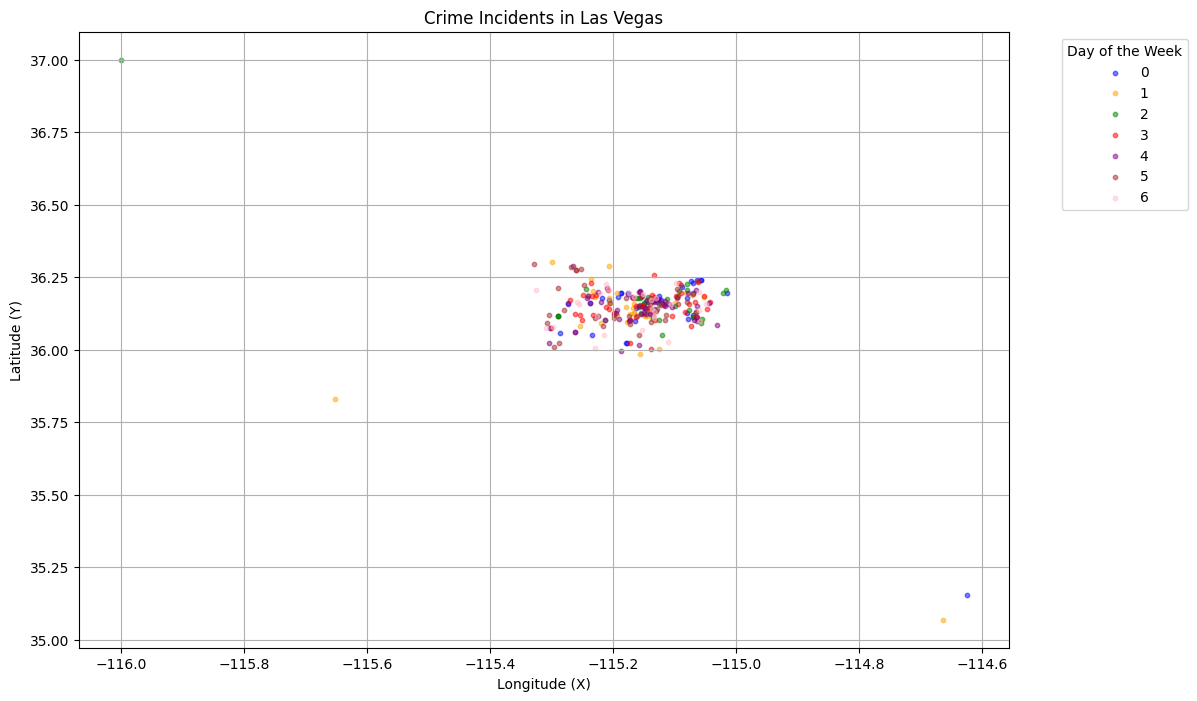

In [53]:
import matplotlib.pyplot as plt

# Define colors for each day of the week
day_colors = {
    0: 'blue',     # Monday
    1: 'orange',   # Tuesday
    2: 'green',    # Wednesday
    3: 'red',      # Thursday
    4: 'purple',   # Friday
    5: 'brown',    # Saturday
    6: 'pink'      # Sunday
}

# Scatter plot the crime incidents
plt.figure(figsize=(12, 8))
for day in df['DayOfWeek'].unique():
    day_data = df[df['DayOfWeek'] == day]
    plt.scatter(day_data['X'], day_data['Y'], label=day, c=day_colors[day], alpha=0.5, s=10)

plt.title('Crime Incidents in Las Vegas')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.legend(title='Day of the Week', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()


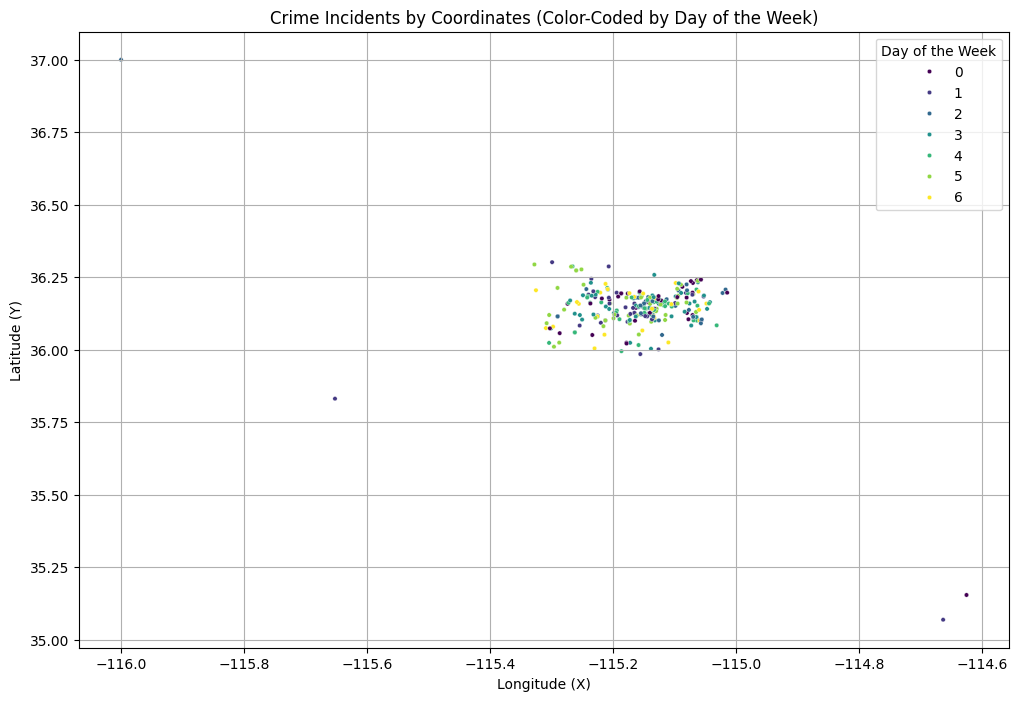

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot with the color indicating the day of the week
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='DayOfWeek', palette='viridis', s=10)
plt.title('Crime Incidents by Coordinates (Color-Coded by Day of the Week)')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.legend(title='Day of the Week')
plt.grid(True)
plt.show()



In [55]:
import pandas as pd

# Assuming you already have the 'DayOfWeek' column in your DataFrame
day_of_week_counts = df['DayOfWeek'].value_counts()

# Sort the days by the number of crimes reported
sorted_day_of_week_counts = day_of_week_counts.sort_values(ascending=False)

# Create a DataFrame for the result
result_df = pd.DataFrame({'DayOfWeek': sorted_day_of_week_counts.index, 'Number of Crimes': sorted_day_of_week_counts.values})

# Display the table
print(result_df)


   DayOfWeek  Number of Crimes
0          4                51
1          3                44
2          5                43
3          0                40
4          1                37
5          2                32
6          6                28


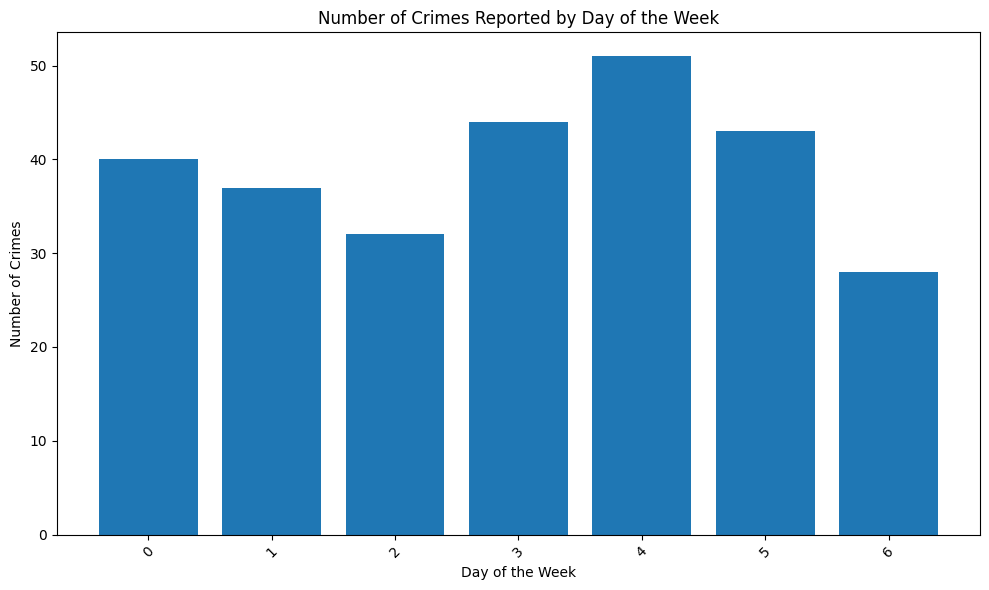

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'DayOfWeek' column in your DataFrame
day_of_week_counts = df['DayOfWeek'].value_counts()

# Sort the days by the number of crimes reported
sorted_day_of_week_counts = day_of_week_counts.sort_values(ascending=False)

# Create a DataFrame for the result
result_df = pd.DataFrame({'DayOfWeek': sorted_day_of_week_counts.index, 'Number of Crimes': sorted_day_of_week_counts.values})

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(result_df['DayOfWeek'], result_df['Number of Crimes'])

# Set labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes Reported by Day of the Week')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()
